# Yahooニュースのスクレイピング
今回はYahooニュースのスクレイピングを行いました。  
データ取得・分析に役立てていただきたく、今回構築した関数を紹介します！  
### 必要な知識
Python
BeautifulSoup

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import itertools
import pandas as pd, numpy as np
import os
import glob
import pathlib
import re
import janome
import jaconv
from janome.tokenizer import Tokenizer
from janome.analyzer import Analyzer
from janome.charfilter import *
import string
import MeCab
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import unicodedata
from gensim import corpora
from gensim import models
from pprint import pprint
import time
import math

import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn import preprocessing

In [2]:
# MeCabの辞書にNEologdを指定。
# mecabは携帯素解析用、wakatiは分かち書き用
mecab = MeCab.Tagger('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd/')
wakati = MeCab.Tagger("-Owakati -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd/")

In [3]:
# 形態素解析を行う関数を定義
# ファイルを入力するとファイルを出力し、文字列を渡すと文字列を返します。引数fileで変更します。  
# 単に分かち書きしたいだけの場合は引数にmecab=wakatiとすると実現できます。
def MecabMorphologicalAnalysis(path='./text.txt', output_file='wakati.txt', mecab=mecab, file=False):
    mecab_text = ''
    if file:
        with open(path) as f:
            for line in f:
                mecab_text += mecab.parse(line)
        with open(output_file, 'w') as f:
            print(mecab_text, file=f)
    else:
        for path in path.split('\n'):
            mecab_text += mecab.parse(path)
        return mecab_text

In [4]:
def sortedTFIDF(sentences):
    
    # 単語にIDを添付します。
    dictionary = corpora.Dictionary(sentences)
    
    # 作品ごとの単語の出現回数をカウント
    corpus = list(map(dictionary.doc2bow, sentences))
    
    # 単語ごとにTF-IDFを算出
    test_model = models.TfidfModel(corpus)
    corpus_tfidf = test_model[corpus]
    
    # ID:TF-IDF → TF-IDF:単語 に変換。TF-IDFを左に持ってくることで、sortedを用いてTF-IDFを基準にソートすることができます。
    texts_tfidf = []
    for doc in corpus_tfidf:
        text_tfidf = []
        for word in doc:
            text_tfidf.append([word[1], dictionary[word[0]]])
        texts_tfidf.append(text_tfidf)
    
    # TF-IDFを基準にソートを行います。
    sorted_texts_tfidf = []
    for text in texts_tfidf:
        sorted_text = sorted(text, reverse=True)
        sorted_texts_tfidf.append(sorted_text)

    return sorted_texts_tfidf

In [5]:
def YahooNews(n=30):
    url = "https://news.yahoo.co.jp/topics/top-picks"
    URL = "https://news.yahoo.co.jp/"
    res = requests.get(url)
    soup = BeautifulSoup(res.text, "html.parser")
    all_page_links = []
    all_page_links.append(url)
    all_links = []
    while True:
        try:
            next = soup.find("li", class_="pagination_item-next").find("a")["href"]
            next_link = URL + next
            all_page_links.append(next_link)
            next_res = requests.get(next_link)
            soup = BeautifulSoup(next_res.text, "html.parser")
        except:
            break
            
    title_list = []
    category_list = []
    text_list = []
    for url in all_page_links: # all_page_links: 全てのニュースのリスト
            res = requests.get(url) # url: 25個分のニュースのリスト
            soup = BeautifulSoup(res.text, "html.parser")
            page_soup = soup.find_all("a", class_="newsFeed_item_link")
            for href in page_soup:
                link = href["href"] # link: 一つのニュースのリンク(本文は一部のみ)
                all_links.append(link)
    
    if len(all_links) <= n:
        n = len(all_links)
    
    i = 0
    for link in all_links:
        link_res = requests.get(link)
        href_soup = BeautifulSoup(link_res.text, "html.parser")
        try:
            title = href_soup.find("h1", class_=re.compile("^sc")).string
        except:
            continue
        title_link = href_soup.find("a", class_="sc-eAyhxF")["href"] # title_link: 本文
        res = requests.get(title_link)
        soup = BeautifulSoup(res.text, "html.parser")

        category = soup.find_all("li", class_="current")
        try:
            category = category[1].string
        except:
            continue
        else:
            for tag in soup.find_all(["a"]):
                tag.decompose()
            try:
                soup = soup.find("div", class_="article_body").get_text()
                soup = symbol_removal(soup)
                
                text_list.append(soup)
                title_list.append(title)
                category_list.append(category)
                i += 1 # 本文が正常に保存できたことをトリガーにしてカウントを一つ増やすことにします。
                pro_bar = ('=' * math.ceil(i / (n / 20))) + (' ' * int((n / (n / 20)) - math.ceil(i / (n / 20))))
                print('\r[{0}] {1}記事'.format(pro_bar, i), end='')
                if i >= n:
                    df = pd.DataFrame({'title': title_list, 'category': category_list, 'text': text_list})
                    return df
            except:
                continue
    df = pd.DataFrame({'title': title_list, 'category': category_list, 'text': text_list})
    return df

In [6]:
def symbol_removal(soup):
    soup = unicodedata.normalize("NFKC", soup)
    exclusion = "「」『』【】《》≪≫、。・◇◆" + "\n" + "\r" + "\u3000"
    soup = soup.translate(str.maketrans("", "", string.punctuation  + exclusion))
    return soup

In [7]:
df = YahooNews(1000)

[====================] 466記事

In [8]:
df.shape

(466, 3)

In [9]:
df.head()

,title,category,text
0,鬼滅の刃 歴代興収が10位に,エンタメ,10月16日に公開されたアニメ映画劇場版鬼滅の刃無限列車編の最新の興行収入が2日発表された...
1,ニッチェ近藤が結婚を報告,エンタメ,お笑いコンビニッチェの近藤くみこ37が2日所属事務所マセキ芸能社の公式サイトを通じてかねて...
2,首相 学術会議は既得権益化,国内,衆院予算委員会は2日午前菅義偉首相と全閣僚が出席して基本的質疑に入った 首相は日本学術会議...
3,紅白司会 紅組は二階堂ふみ,エンタメ,NHKは2日今年の大晦日に放送される第71回 NHK紅白歌合戦12月31日午後7時30分の...
4,松井秀喜氏が愛した店閉店,スポーツ,お世話になってばかりで寂しいです巨人やヤンキースなどで活躍した松井秀喜氏46が知人を介してあ...


In [10]:
texts = []
for i in range(len(df)):
    texts.append(MecabMorphologicalAnalysis(df['text'][i], mecab=wakati))

In [11]:
# 分かち書きができたか確認します。5作品を表示。
for i, text in enumerate(texts):
    if i < 5:
        display(text[:100])

'10月16日 に 公開 さ れ た アニメ映画 劇場版 鬼滅の刃 無限 列車 編 の 最新 の 興行収入 が 2日 発表 さ れ た 初日 から 17日間 1日 まで の 興行収入 が 興行収入 15'

'お笑いコンビ ニッチェ の 近藤くみこ 37 が 2日 所属事務所 マセキ芸能社 の 公式サイト を 通じ て かね て よ てり 交際 し て い た 一般男性 と 結婚 し たこ を 報告 し た'

'衆院 予算委員会 は 2日 午前 菅義偉 首相 と 全閣僚 が 出席 し て 基本的 質疑 に 入っ た 首相 は 日本学術会議 の 会員 選考 について 閉鎖 的 で 既得権益 の よう に なっ '

'NHK は 2日 今年 の 大晦日 に 放送 さ れる 第 71回 NHK紅白歌合戦 12月31日 午後7時 30分 の 司会者 を 発表 し た 白組 は 俳優 の 大泉 洋紅 組 は 女優 の 二'

'お世話 に なっ て ばかり で 寂しい です 巨人 や ヤンキース など で 活躍 し た 松井秀喜 氏 46 が 知人 を 介し て ある 居酒屋 の 店長 に こんな メッセージ を 送っ て '

In [12]:
# リストに変換
sentences = []
for text in texts:
    text_list = text.split(' ')
    sentences.append(text_list)

In [13]:
# まずdocumentsを作り、モデルに渡す。
documents1 = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentences)]
model1 = Doc2Vec(documents1, vector_size=100, window=7, min_count=1)

In [14]:
# モデルに渡したdocumentsの中身は番号と本文が対応したリストです。ここでは参考のため、作者も表示しています。
for i, doc in enumerate(documents1):
    print(doc[1], df['title'][i], df['category'][i], doc[0][:8])

[0] 鬼滅の刃 歴代興収が10位に エンタメ ['10月16日', 'に', '公開', 'さ', 'れ', 'た', 'アニメ映画', '劇場版']
[1] ニッチェ近藤が結婚を報告 エンタメ ['お笑いコンビ', 'ニッチェ', 'の', '近藤くみこ', '37', 'が', '2日', '所属事務所']
[2] 首相 学術会議は既得権益化 国内 ['衆院', '予算委員会', 'は', '2日', '午前', '菅義偉', '首相', 'と']
[3] 紅白司会 紅組は二階堂ふみ エンタメ ['NHK', 'は', '2日', '今年', 'の', '大晦日', 'に', '放送']
[4] 松井秀喜氏が愛した店閉店 スポーツ ['お世話', 'に', 'なっ', 'て', 'ばかり', 'で', '寂しい', 'です']
[5] ハンド宮崎大輔容疑者を逮捕 国内 ['FNN', 'プライムオンラインハンドボール', '元日本代表', 'の', '宮崎大輔', '選手', 'が', '2日']
[6] 尚弥の超速パンチ 実は新兵器 スポーツ ['試合前', 'スパー', 'で', '見せ', 'た', '進化', '衝撃', 'の']
[7] やっぱり青学が本命?箱根駅伝 スポーツ ['前回大会', 'の', 'トップ3', 'で', 'ある', '東海大', '青学大', '駒大']
[8] WHO事務局長が自主隔離 国際 ['AFP', '時事', '更新', '世界保健機関', 'WHO', 'の', 'テドロスアダノムゲブレイェスス', 'Tedros']
[9] 西武 内海哲也と契約更新へ スポーツ ['西武', 'が', '内海哲也', '投手', '38', 'と', '来季契約', '更新']
[10] 尖閣周辺に中国船 年最多更新 国内 ['沖縄県', '尖閣諸島', '周辺', 'の', '領', '海外', '側', 'に']
[11] 千葉市長 知事選出馬を表明 地域 ['来春', 'の', '知事選', 'で', '千葉市', 'の', '熊谷俊人', '市長']
[12] 高橋留美子さんに紫綬褒章 エンタメ ['政府', 'は', '2020年', '秋', 'の', '褒章', '受章', '者']
[13] 札幌2歳衰弱死 

In [15]:
# 6は太宰治の「人間失格」です。
# 自分の人生に迷いながら苦悩するみたいな話だったはず。
# 最後は精神病院送りにされて、、重苦しいまま終わる感じだった。
ranking1 = model1.docvecs.most_similar(15, topn=50)

In [16]:
ranking1[:5] # コサイン類似度が大きい作品トップ5

[(104, 0.9998716115951538),
 (421, 0.9998632669448853),
 (65, 0.999862551689148),
 (169, 0.9998478889465332),
 (225, 0.9998416900634766)]

In [17]:
ranking1[-5:] # コサイン類似度が小さい作品トップ5

[(303, 0.999794602394104),
 (16, 0.999794602394104),
 (235, 0.9997944831848145),
 (64, 0.999794065952301),
 (460, 0.9997934699058533)]

In [18]:
le1 = preprocessing.LabelEncoder()

vecs1 = []
for i in range(len(model1.docvecs)):
    vecs1.append(model1.docvecs[i])
category1 = list(df['category'])
df1 = pd.DataFrame(vecs1)
df1.insert(0, 'category', category1)
df1.category = le1.fit_transform(df1.category)
dfs1 = df1.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

In [19]:
pca1 = PCA()
pca1.fit(dfs1)
feature1 = pca1.transform(dfs1)

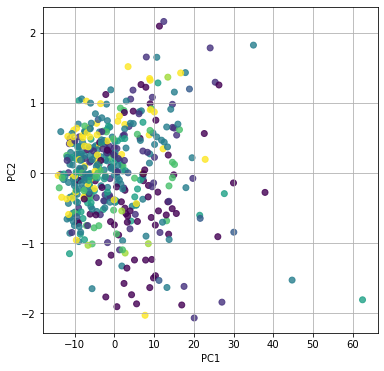

In [20]:
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(6, 6))
plt.scatter(feature1[:, 0], feature1[:, 1], alpha=0.8, c=list(df1.iloc[:, 0]))
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [21]:
# sentencesの中身を確認
for i, sentence in enumerate(sentences):
    if i < 5:
        print(sentence[:10])

['10月16日', 'に', '公開', 'さ', 'れ', 'た', 'アニメ映画', '劇場版', '鬼滅の刃', '無限']
['お笑いコンビ', 'ニッチェ', 'の', '近藤くみこ', '37', 'が', '2日', '所属事務所', 'マセキ芸能社', 'の']
['衆院', '予算委員会', 'は', '2日', '午前', '菅義偉', '首相', 'と', '全閣僚', 'が']
['NHK', 'は', '2日', '今年', 'の', '大晦日', 'に', '放送', 'さ', 'れる']
['お世話', 'に', 'なっ', 'て', 'ばかり', 'で', '寂しい', 'です', '巨人', 'や']


In [22]:
# 自作のsortedTFIDF関数を用いてTF-IDF順にソートされたリストを得る。
sorted_texts_tfidf = sortedTFIDF(sentences)

In [23]:
# 作品ごとにTF-IDFの高い単語を確認
for i, tfidf in enumerate(sorted_texts_tfidf):
    if i < 5:
        print('%s.' % i, '〜%s〜' % df['title'][i]) # 一応タイトルも表示
        pprint(tfidf[:10])
        print('')

0. 〜鬼滅の刃 歴代興収が10位に〜
[[0.34561730502482435, '興行収入'],
 [0.3346700856098662, '億'],
 [0.24505678502326675, '円'],
 [0.2167399272892577, '公開'],
 [0.20737038301489458, '鬼'],
 [0.17915377477976968, '動員'],
 [0.17280865251241218, '無限'],
 [0.17280865251241218, '列車'],
 [0.14932676925199329, '炭'],
 [0.12675718898578303, '万']]

1. 〜ニッチェ近藤が結婚を報告〜
[[0.3488586476327346, 'ニッチェ'],
 [0.26164398572455094, '近藤くみこ'],
 [0.2574769142322737, '致し'],
 [0.23212700791578275, '近藤'],
 [0.21486068276303485, '入籍'],
 [0.1744293238163673, '江上'],
 [0.1744293238163673, '宜しく'],
 [0.16359070786543706, 'お願い'],
 [0.15475133861052182, '似顔絵'],
 [0.15388144422744035, '報告']]

2. 〜首相 学術会議は既得権益化〜
[[0.4654665878293501, '会員'],
 [0.23292522083969588, '首相'],
 [0.22446367256303948, '任命'],
 [0.16964739242846888, '踏襲'],
 [0.16964739242846888, '正当'],
 [0.16964739242846888, '既得権益'],
 [0.16964739242846888, '大塚拓'],
 [0.16964739242846888, '90万人'],
 [0.15050887371281918, '質疑'],
 [0.15050887371281918, '問題視']]

3. 〜紅白司会 紅組は二階堂ふみ〜
[[0.3513824098115

In [183]:
all_title = []
for tfidf in sorted_texts_tfidf:
    title = []
    for word in tfidf[:100]: # 100語に絞る
        title.append(word[1])
    all_title.append(title)

In [184]:
# all_titleリストの中身を確認
for i, text in enumerate(all_title):
    if i < 5:
        print(text[:10])

['興行収入', '億', '円', '公開', '鬼', '動員', '無限', '列車', '炭', '万']
['ニッチェ', '近藤くみこ', '致し', '近藤', '入籍', '江上', '宜しく', 'お願い', '似顔絵', '報告']
['会員', '首相', '任命', '踏襲', '正当', '既得権益', '大塚拓', '90万人', '質疑', '問題視']
['エール', '責任者', '大泉', '音楽番組', '総合司会', '大河ドラマ', '二階堂', '紅白', '白組', '内村光良']
['君', '松井', '松井氏', 'です', '安倍氏', '吉', 'もー', 'ん', '店', '清原']


In [185]:
# Doc2Vecモデルに重要単語リストall_titleを渡します。
documents2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_title)]
model2 = Doc2Vec(documents2, vector_size=100, window=5, min_count=1)

In [186]:
# 結果と照らし合わせやすいように、番号と作品の一覧を表示
for i, doc in enumerate(documents2):
    print(doc[1], df['title'][i], df['category'][i], doc[0][:8])

[0] 鬼滅の刃 歴代興収が10位に エンタメ ['興行収入', '億', '円', '公開', '鬼', '動員', '無限', '列車']
[1] ニッチェ近藤が結婚を報告 エンタメ ['ニッチェ', '近藤くみこ', '致し', '近藤', '入籍', '江上', '宜しく', 'お願い']
[2] 首相 学術会議は既得権益化 国内 ['会員', '首相', '任命', '踏襲', '正当', '既得権益', '大塚拓', '90万人']
[3] 紅白司会 紅組は二階堂ふみ エンタメ ['エール', '責任者', '大泉', '音楽番組', '総合司会', '大河ドラマ', '二階堂', '紅白']
[4] 松井秀喜氏が愛した店閉店 スポーツ ['君', '松井', '松井氏', 'です', '安倍氏', '吉', 'もー', 'ん']
[5] ハンド宮崎大輔容疑者を逮捕 国内 ['宮崎', '宮崎大輔', 'ハンドボール', '容疑者', '引っ張る', '名古屋市内', '暴行', '元日本代表']
[6] 尚弥の超速パンチ 実は新兵器 スポーツ ['パンチ', 'モロニー', '井上', '発', '黒田', '速', '的中', 'モンスター']
[7] やっぱり青学が本命?箱根駅伝 スポーツ ['青学大', '2年', '駒大', '東海大', '4年', '箱根駅伝', '登録', 'エース']
[8] WHO事務局長が自主隔離 国際 ['自主', 'WHO', '隔離', '陽性', '人物', '接触', '症状', '断ち切り']
[9] 西武 内海哲也と契約更新へ スポーツ ['内海哲也', '人的補償', '登板', '来季', '西武', '年', '巨人', '昨季']
[10] 尖閣周辺に中国船 年最多更新 国内 ['隻', '船', '航行', '尖閣', '周辺', '確認', '領有権', '重ねる']
[11] 千葉市長 知事選出馬を表明 地域 ['知事選', '県政', '▽', '熊谷氏', '市長選', '政党', '千葉', '出馬']
[12] 高橋留美子さんに紫綬褒章 エンタメ ['受章', '紫綬褒章', '少年漫画', 'ラブコメ', '褒章', '中学', '誌', '連載']
[13] 札幌2歳衰弱死 母

In [187]:
ranking2 = model2.docvecs.most_similar(101, topn=50) # 今回も太宰治の「人間失格」で検証

In [188]:
ranking2[:5]

[(231, 0.33720505237579346),
 (255, 0.30390194058418274),
 (8, 0.2814445495605469),
 (403, 0.2749409079551697),
 (243, 0.2732076644897461)]

In [189]:
df['title'][101]

'トランプ氏 接戦州で差縮める'

In [190]:
df['text'][101]

' ワシントン横堀裕也米大統領選は10月30日11月3日の投開票まであと4日に迫り共和党のドナルドトランプ大統領と民主党のジョーバイデン前副大統領の陣営がラストスパートをかけている勝敗の鍵を握る接戦州ではバイデン氏のリードが縮まっておりトランプ氏が懸命の巻き返しを見せている 米政治情報サイトリアルクリアポリティクスはペンシルベニアミシガンウィスコンシンノースカロライナフロリダアリゾナの6州を接戦州として挙げる6州に限った支持率は10月に入りバイデン氏のリードが最大5ポイントあったが30日時点では31ポイント差となっている トランプ氏は30日ウィスコンシンなど3州を回り経済政策をアピールした31日以降残り3日間で14回の支持者集会を開く計画だバイデン氏もウィスコンシンなど3州で遊説しトランプ氏の新型コロナウイルス対策を批判した感染拡大を踏まえて過密な遊説日程は避けてきたが最終盤でピッチを上げている'

In [191]:
le2 = preprocessing.LabelEncoder()

vecs2 = []
for i in range(len(model2.docvecs)):
    vecs2.append(model2.docvecs[i])
category2 = list(df['category'])
df2 = pd.DataFrame(vecs2)
df2.insert(0, 'category', category2)
df2.category = le2.fit_transform(df2.category)

In [192]:
df2

,category,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,0.000055,-0.001780,-0.001192,0.001671,-0.002648,-0.003717,0.002220,0.005947,0.001250,...,0.000399,0.002277,0.002317,-0.001236,0.004504,0.000751,-0.000835,-0.003304,-0.000365,0.002644
1,0,0.001256,-0.000019,-0.003867,-0.003451,-0.002340,0.004176,-0.002222,0.006748,-0.006415,...,0.003701,0.003497,0.000995,-0.001906,0.003267,0.000144,-0.002269,-0.004672,-0.000837,0.002059
2,3,-0.004570,-0.004907,0.005121,0.003627,0.005634,-0.000120,-0.000234,-0.000272,-0.000880,...,-0.007114,-0.001124,-0.006315,-0.001791,-0.000692,0.001750,-0.004727,-0.003754,0.005516,-0.002338
3,0,-0.000911,0.004853,0.002477,-0.003627,-0.000201,-0.003725,-0.000556,-0.001056,-0.000539,...,-0.000037,0.005899,0.003217,-0.002295,0.002786,-0.003410,0.000154,-0.005031,0.000440,-0.001378
4,1,0.003571,0.002367,-0.002323,0.003822,-0.007171,-0.001429,-0.004667,0.004557,0.002658,...,0.000307,0.004926,0.001851,-0.002607,-0.000571,-0.001591,-0.002040,0.000827,-0.003149,-0.005466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0,0.004280,-0.002470,-0.005427,0.000513,-0.002521,0.000981,-0.003828,0.006030,-0.003521,...,0.003681,0.003625,0.002378,-0.001850,-0.002230,0.002686,-0.002629,-0.002501,-0.002214,-0.002786
462,7,0.002338,-0.005043,0.005029,0.000315,0.003134,0.001025,0.000968,0.000963,0.000214,...,-0.004219,0.000667,0.001582,-0.004277,0.001481,-0.001647,-0.003123,0.001179,-0.001761,-0.003409
463,0,-0.001111,-0.003493,-0.005299,-0.002789,0.001043,0.003118,-0.003960,0.005601,0.002197,...,0.002266,-0.000403,0.004977,-0.001129,-0.000121,-0.002684,-0.000204,0.002481,0.002379,-0.002867
464,7,0.004307,-0.002268,0.001355,0.001756,0.006474,0.002099,0.003219,0.003064,-0.003651,...,0.003559,-0.003274,-0.004987,0.002601,-0.001470,0.004482,0.002271,-0.002280,0.005992,0.003762


In [193]:
dfs2 = df2.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
# dfs.head()

In [194]:
pca2 = PCA()
pca2.fit(dfs2)
feature2 = pca2.transform(dfs2)

In [195]:
# 主成分得点
pd.DataFrame(feature2, columns=["PC{}".format(x + 1) for x in range(len(dfs2.columns))]).head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,-1.628984,-0.187189,0.167392,-0.816745,0.175931,0.053960,1.171391,-1.835201,0.488463,0.741481,...,0.303163,-0.995779,-0.153870,-0.821013,-0.697037,-0.785433,-0.045409,0.163763,-0.250249,0.106707
1,-0.815405,0.259694,-0.752389,0.087548,0.198405,-0.345162,-1.539719,1.791213,0.290297,0.307802,...,0.238724,0.344030,0.578517,-0.419135,-0.755515,0.114644,-0.315248,0.080999,0.142892,-0.517395
2,8.615745,-0.282955,1.455042,0.705974,1.282776,1.181854,-0.243228,0.561958,-0.616677,0.925125,...,0.820436,0.450977,-0.116950,-0.600686,-0.837568,-0.210843,-0.724672,-0.073554,0.500294,0.158292
3,-1.763689,-0.941134,0.964255,-1.671127,0.746151,1.550326,-0.339842,0.501190,2.157670,-1.593180,...,0.990611,-0.161058,-0.221914,0.194173,-0.543590,0.006711,-0.377009,-0.426342,0.395981,-0.468161
4,-1.260981,0.869053,-0.082990,0.296790,-0.422459,1.878948,-0.683016,0.554924,1.878056,-1.047216,...,-0.528869,-0.670324,-0.164577,-0.932552,0.834836,-0.427195,-1.047726,0.072271,0.412139,-0.068150


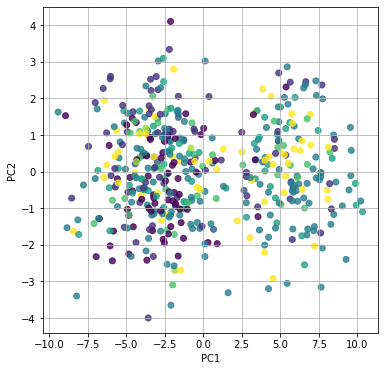

In [196]:
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(6, 6))
plt.scatter(feature2[:, 0], feature2[:, 1], alpha=0.8, c=list(df2.iloc[:, 0]))
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()